*Copyright (c) Microsoft Corporation. All rights reserved.*                 
*Licensed under the MIT License.*

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

# Interpreting Bag of Words Text Classification models

This notebook show a set by step implementation of traditional machine algorithms with a bag of words representation as an interpretable model using feature importances.

###### Note:
* This example walks through a logistic regression baseline with a simple Bag of Words encoding. However, any model that follows sklearn's classifier API should be supported natively or with minimal tweaking.
* The interpreter supports interpretations using either coefficients associated with linear models or feature importances associated with ensemble models.
* For larger text datasets, the classifier relies on scipy's sparse representations to keep the dataset in memory.

In [2]:
#import libraries
import sys
import os
import json
import pandas as pd
import numpy as np
import scipy
import string
from scrapbook.api import glue
# sklearn
from sklearn.metrics import classification_report, accuracy_score
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.base import TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.base import TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_recall_fscore_support
# spacy and nlp recipes
import spacy
from spacy.lang.en.stop_words import STOP_WORDS
from spacy.lang.en import English
from utils_nlp.dataset.multinli import load_pandas_df
# for visualizations
import matplotlib.pyplot as plt
import html
from IPython.core.display import display, HTML

## Introduction

The notebook is built on features made available by [Sci-kit Learn](https://scikit-learn.org/stable/) and [spacy](https://spacy.io/) for easier compatibiltiy with popular tookits.                     
The notebook also relies on the pip installable "utils_nlp.dataset.multinli" package from Microsoft's [NLP-recipes](https://github.com/microsoft/nlp-recipes/tree/master/utils_nlp) open source package for dataloading purposes.               


### An Overview

The [Bag of Words](https://en.wikipedia.org/wiki/Bag-of-words_model) allows a 1:1 mapping from the individual words to their respective frequencies in the Document-term matrix.

We use spacy's medium language [model](https://spacy.io/models/en#en_core_web_md) that's trained on common crawl for text preprocessing.

Set configuration parameters

In [3]:
SPACY_LANG_MODEL = 'en_core_web_md'
DATA_FOLDER = './temp'
TRAIN_SIZE = 0.8
TEST_SIZE = 0.2

Load data

In [4]:
df = load_pandas_df(DATA_FOLDER, "train")
df = df[df["gold_label"]=="neutral"]  # get unique sentences

# fetch documents and labels from data frame
X_str = df['sentence1'] # the document we want to analyze
ylabels = df['genre'] # the labels, or answers, we want to test against

## Configure preprocessessing setup

Each text document in the dataset under goes the following preprocessing steps during conversion into tokens:

* Use spacy's English parser to parse document.
* Convert to lower case.
* Strip off white space surrounding each word.
* [lemmatize](https://en.wikipedia.org/wiki/Lemmatisation) based on spacy's language model.
* Remove stop words and punctuation to obtain tokens.

Create list of stopwords and punctuation marks

In [5]:
nlp = spacy.load(SPACY_LANG_MODEL)
stop_words = spacy.lang.en.stop_words.STOP_WORDS
punctuations = string.punctuation

Load Parser

In [6]:
parser = English()

# configure tokenizer function
# if keep_idx is true, allows inverse mapping back to text from tokens, for future text highlighting.
def spacy_tokenizer(sentence, keep_idx = False):
    # Creating our token object, which is used to create documents with linguistic annotations.
    mytokens = parser(sentence)
        
    # Lemmatizing each token, removing blank space and converting each token into lowercase
    mytokens = [ word.lemma_.lower().strip() if word.lemma_ != "-PRON-" else word.lower_ for word in mytokens ]
    
    # Removing stop words
    if keep_idx is True:
        mytokens = [ word if word not in stop_words and word not in punctuations else "empty_token" for word in mytokens]
        return mytokens
    else:
        mytokens = [ word for word in mytokens if word not in stop_words and word not in punctuations ]
        return mytokens

## Preprocess training data and labels and cast into correct format

* Count tokens and construct sparse term document matrix.
* Vectorize tokens into counts.
* Convert labels from strings into integers.

###### Note: Vocabulary

* *The vocabulary is compiled from the dataset. This means that any word that does not appear in the Dataset is not a part of the vocabulary. This also means that the vocabulary varies with the dataset.*           
* *Every word that appear one or more times is considered to be part of the vocab.*
* *However, The sklearn countvectorizer allows addition of a custom vocabulary as an input parameter.*

Convert tokens to BOW count vector

In [21]:
countvectorizer = CountVectorizer(tokenizer = spacy_tokenizer, ngram_range=(1,1))
X_vec = countvectorizer.fit_transform(X_str)

Encode labels as numbers

In [8]:
labelencoder = LabelEncoder()
# convert from pandas dataframe to ndarray
ylabels = np.asarray(ylabels[:]).reshape(-1,1)
ylabels = labelencoder.fit_transform(ylabels)

C:\Users\anpimple\AppData\Local\Continuum\anaconda3\envs\interpret_env\lib\site-packages\sklearn\preprocessing\label.py:235: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


## Configure training setup

* Split data into train and test using a random shuffle
* load desired classifier. In this case, Logistic Regression.
* Setup grid search for hyperparameter optimization and train model. Edit the hyper parameter range to search over as per your model.
* Fit models to train set

In [9]:
# Split into training and test set 
X_train, X_test, y_train, y_test = train_test_split(X_vec,ylabels, train_size = TRAIN_SIZE, 
                                                    test_size = TEST_SIZE, random_state=0)
print("X_train shape =" + str(X_train.shape))
print("y_train shape =" + str(y_train.shape))
print("X_train data structure = "+ str(type(X_train)))

X_train shape =(104720, 49721)
y_train shape =(104720,)
X_train data structure = <class 'scipy.sparse.csr.csr_matrix'>


In [10]:
# Set the parameters using cross-validation
tuned_parameters = [{'solver': ['saga'],'multi_class': ['multinomial'], 'C': [10**4]}]

model =  LogisticRegression()
classifier_CV = GridSearchCV(model, tuned_parameters, cv=3, scoring='accuracy')
classifier_CV.fit(X_train,y_train)

C:\Users\anpimple\AppData\Local\Continuum\anaconda3\envs\interpret_env\lib\site-packages\sklearn\linear_model\sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


GridSearchCV(cv=3, error_score='raise-deprecating',
             estimator=LogisticRegression(C=1.0, class_weight=None, dual=False,
                                          fit_intercept=True,
                                          intercept_scaling=1, l1_ratio=None,
                                          max_iter=100, multi_class='warn',
                                          n_jobs=None, penalty='l2',
                                          random_state=None, solver='warn',
                                          tol=0.0001, verbose=0,
                                          warm_start=False),
             iid='warn', n_jobs=None,
             param_grid=[{'C': [10000], 'multi_class': ['multinomial'],
                          'solver': ['saga']}],
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='accuracy', verbose=0)

## Results

* Obtain best model and corresponding hyper parameters
* report Accuracy, F1 score, Precision and Recall.

In [11]:
# obtain best classifier and hyper params
classifier = classifier_CV.best_estimator_
print("best classifier: " + str(classifier_CV.best_params_))

best classifier: {'C': 10000, 'multi_class': 'multinomial', 'solver': 'saga'}


report performance metrics

In [ ]:
mean_accuracy = classifier.score(X_test, y_test, sample_weight=None)
print("accuracy = " + str(mean_accuracy*100) + "%")
y_pred = classifier.predict(X_test)
[precision,recall,fscore,support] = precision_recall_fscore_support(y_test, y_pred,average='macro')

for testing

In [12]:
glue("accuracy", mean_accuracy)
glue("precision", precision)
glue("recall", recall)
glue("f1", fscore)

print ("[precision,recall,fscore,support] = " + str([precision,recall,fscore,support]))

accuracy = 83.70511841100077%


[precision,recall,fscore,support] = [0.8400764106445477, 0.8366450456717711, 0.8373747112946287, None]


## Compute global importances

Visualize the most and least important words for each class over the entire dataset
Choose which label's importances to visualize 

In [13]:
print("The class names are as follows")
print(labelencoder.classes_)
label_name = "fiction"

The class names are as follows
['fiction' 'government' 'slate' 'telephone' 'travel']


Obtain the top feature ids for the selected class label.           
Map top features back to words.

In [ ]:
label_coefs_all =  classifier.coef_
label_coefs = label_coefs_all[labelencoder.transform([label_name]),:]
sorting_ids = (np.flip(np.argsort(np.abs(label_coefs)))).flatten()
top_ids = sorting_ids[0:20] # view top 20 features per label
top_words = [countvectorizer.get_feature_names()[i] for i in top_ids]
top_importances = [label_coefs[0,i] for i in top_ids]

Plot the feature importances

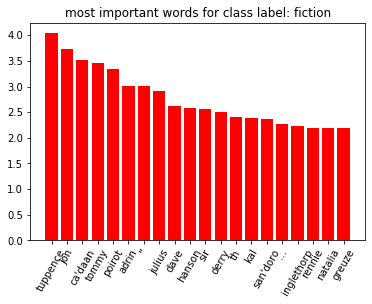

In [16]:
plt.figure()
plt.title("most important words for class label: " + str(label_name) )
plt.bar(range(len(top_importances)), top_importances,
       color="r", align="center")
plt.xticks(range(len(top_importances)), top_words, rotation=60)
plt.show()

## Compute local importances

Enter any document & label pair that needs to be interpreted

In [17]:
document = "I travelled to the beach. I took the train. I saw faries, dragons and elves"
label_name = "fiction"

Obtain the top feature ids for the selected class label

In [18]:
label_coefs = classifier.coef_[labelencoder.transform([label_name]),:]
parsed_sentence = []
for i in parser(document):
    parsed_sentence += [str(i)]

doc_tokens = spacy_tokenizer(document, keep_idx = True)
word_ids = [None if word is 'empty_token' else countvectorizer.vocabulary_.get(word) for word in doc_tokens]
word_importances = [0 if idx==None else label_coefs[0,idx] for idx in word_ids]

Visualize local feature importances as a heatmap over words in the document

In [20]:
# Prevent special characters like & and < to cause the browser to display something other than what you intended.
def html_escape(text):
    return html.escape(text)

max_alpha = 0.5
highlighted_text = []
for i,word in enumerate(parsed_sentence):
    weight = word_importances[i]
    if weight > 0:
        highlighted_text.append('<span style="background-color:rgba(135,206,250,' + str(abs(weight) / max_alpha) +
                                ');">' + html_escape(word) + '</span>')
    elif weight < 0:
        highlighted_text.append('<span style="background-color:rgba(250,0,0,' + str(abs(weight) / max_alpha) +
                                ');">' + html_escape(word) + '</span>')
    else:
        highlighted_text.append(word)

highlighted_text = ' '.join(highlighted_text)
display(HTML(highlighted_text))